In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
df = pd.read_csv('/kaggle/input/grocery-inventory-and-sales-dataset/Grocery_Inventory_and_Sales_Dataset.csv')

In [3]:
core_features = [
    "Stock_Quantity",
    "Reorder_Level",
    "Reorder_Quantity",
    "Unit_Price",
    "Days_Since_Last_Order",
    "Days_Till_Expiry",
    "Lag_1_Sales",
    "Rolling_3_Sales"
]



In [4]:
# --- Feature Engineering ---
import pandas as pd

# 🔹 Clean Unit_Price column (remove $ and spaces, convert to float)
df["Unit_Price"] = (
    df["Unit_Price"].astype(str)
    .str.replace(r"[^0-9.]", "", regex=True)
    .astype(float)
)

# 🔹 Ensure date columns are datetime
df["Last_Order_Date"] = pd.to_datetime(df["Last_Order_Date"])
df["Expiration_Date"] = pd.to_datetime(df["Expiration_Date"])
df["Date_Received"] = pd.to_datetime(df["Date_Received"])

# 🔹 Days since last order (based on Date_Received)
df["Days_Since_Last_Order"] = (
    (df["Date_Received"] - df["Last_Order_Date"]).dt.days.fillna(0)
)

# 🔹 Days till expiry (from Date_Received to Expiration_Date)
df["Days_Till_Expiry"] = (
    (df["Expiration_Date"] - df["Date_Received"]).dt.days.fillna(0)
)

# 🔹 Sort so lag/rolling features work properly
df = df.sort_values(["Product_ID", "Date_Received"])

# --- Lag & Rolling Features (shifted to prevent leakage) ---
df["Lag_1_Sales"] = df.groupby("Product_ID")["Sales_Volume"].shift(1).fillna(0)
df["Lag_7_Sales"] = df.groupby("Product_ID")["Sales_Volume"].shift(7).fillna(0)

df["Rolling_3_Sales"] = (
    df.groupby("Product_ID")["Sales_Volume"]
      .shift(1)  # shift ensures no leakage
      .rolling(3, min_periods=1).mean()
      .reset_index(level=0, drop=True)
      .fillna(0)
)

df["Rolling_7_Sales"] = (
    df.groupby("Product_ID")["Sales_Volume"]
      .shift(1)
      .rolling(7, min_periods=1).mean()
      .reset_index(level=0, drop=True)
      .fillna(0)
)

# --- Extra Date Features ---
df["Month"] = df["Date_Received"].dt.month
df["Weekday"] = df["Date_Received"].dt.weekday

# --- Categorical Encodings ---
df["Product_ID_Enc"] = df["Product_ID"].astype("category").cat.codes
df["Supplier_ID_Enc"] = df["Supplier_ID"].astype("category").cat.codes
df["Status_Enc"] = df["Status"].astype("category").cat.codes
df["Sales_Log"] = np.log1p(df["Sales_Volume"])


# --- Aggregated Features ---
df["Avg_Sales_Product"] = df.groupby("Product_ID")["Sales_Volume"].transform("mean")
df["Avg_Sales_Supplier"] = df.groupby("Supplier_ID")["Sales_Volume"].transform("mean")
df["Std_Sales_Product"] = df.groupby("Product_ID")["Sales_Volume"].transform("std").fillna(0)
# Example: last 20% of data as test
split_date = df["Date_Received"].quantile(0.8)
train_df = df[df["Date_Received"] <= split_date]
test_df  = df[df["Date_Received"] > split_date]



In [5]:
feature_cols = [
    "Stock_Quantity",
    "Reorder_Level",
    "Reorder_Quantity",
    "Unit_Price",
    "Days_Since_Last_Order",
    "Days_Till_Expiry",
    "Weekday",
    "Month",
    "Product_ID_Enc",
    "Supplier_ID_Enc",
    "Status_Enc", "Sales_Log"
]
target_col = "Sales_Log"

In [6]:
X = df[feature_cols]
y = df[target_col]

In [7]:
X_train, y_train = train_df[feature_cols], train_df[target_col]
X_test, y_test = test_df[feature_cols], test_df[target_col]

# === 8. Train LightGBM model ===
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)
from lightgbm import early_stopping, log_evaluation
params = {
    "objective": "regression",
    "metric": "rmse",
    "boosting_type": "gbdt",
    "learning_rate": 0.1,          # faster learning
    "num_leaves": 127,             # allow deeper splits
    "min_data_in_leaf": 5,         # allow small groups
    "feature_fraction": 0.9,
    "bagging_fraction": 0.9,
    "bagging_freq": 1,
    "verbose": -1,
}



model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, test_data],
    num_boost_round=1000,
    callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(period=100)
    ]
)

Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.0008176	valid_1's rmse: 0.0283412
[200]	training's rmse: 0.000179914	valid_1's rmse: 0.0282809
[300]	training's rmse: 5.24097e-05	valid_1's rmse: 0.0282749
Early stopping, best iteration is:
[252]	training's rmse: 9.29625e-05	valid_1's rmse: 0.0282734


In [8]:
print("Target stats:")
print(df[target_col].describe())

print("\nFeature correlation with target:")
# keep only numeric columns
numeric_df = df.select_dtypes(include=["number"])

# correlation with target
corr_with_target = numeric_df.corr()[target_col].sort_values(ascending=False)
print(corr_with_target)



Target stats:
count    990.000000
mean       4.009188
std        0.426468
min        3.044522
25%        3.688879
50%        4.077537
75%        4.369448
max        4.615121
Name: Sales_Log, dtype: float64

Feature correlation with target:
Sales_Log                  1.000000
Avg_Sales_Product          0.980275
Avg_Sales_Supplier         0.980275
Sales_Volume               0.980275
Inventory_Turnover_Rate    0.065741
Days_Till_Expiry           0.048698
Stock_Quantity             0.029026
Month                      0.025988
Supplier_ID_Enc           -0.004088
Weekday                   -0.004375
Reorder_Level             -0.005382
Product_ID_Enc            -0.005491
Unit_Price                -0.011779
Days_Since_Last_Order     -0.020965
Reorder_Quantity          -0.021904
Status_Enc                -0.054720
Lag_1_Sales                     NaN
Lag_7_Sales                     NaN
Rolling_3_Sales                 NaN
Rolling_7_Sales                 NaN
Std_Sales_Product               NaN
Name

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [9]:
print(df[feature_cols].std().sort_values())


Sales_Log                  0.426468
Status_Enc                 0.819997
Weekday                    2.035382
Month                      3.414330
Unit_Price                 6.491280
Stock_Quantity            26.300775
Reorder_Level             29.095241
Reorder_Quantity          29.521059
Days_Till_Expiry         150.125993
Days_Since_Last_Order    150.485792
Product_ID_Enc           285.932684
Supplier_ID_Enc          285.932684
dtype: float64


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

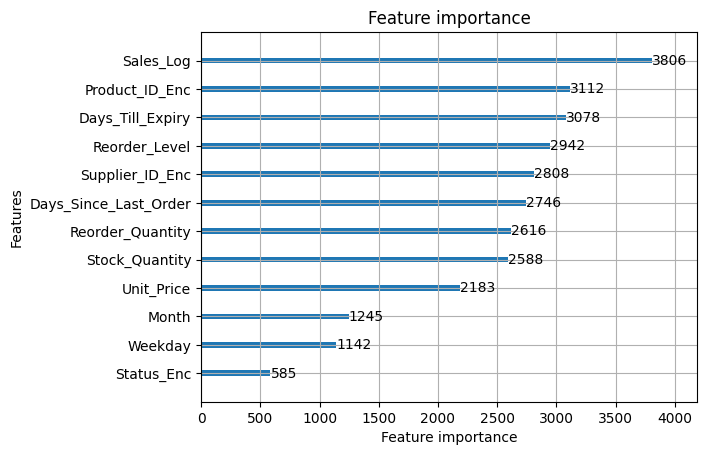

In [10]:
lgb.plot_importance(model, max_num_features=15)


In [11]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# 🔹 Predict on validation set
y_pred = model.predict(X)

# 🔹 Create comparison DataFrame
comparison = pd.DataFrame({
    "Actual": y,
    "Predicted": y_pred
})

# 🔹 Print first few rows
print(comparison.head(10))

# 🔹 Evaluate
rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)
print("RMSE:", rmse)
print("R²:", r2)


       Actual  Predicted
278  3.688879   3.664209
207  4.094345   4.094361
180  3.218876   3.218873
826  4.158883   4.158887
296  3.761200   3.811317
290  4.025352   4.025300
773  4.510860   4.474929
764  4.574711   4.574720
701  4.204693   4.204694
260  4.442651   4.442651
RMSE: 0.01261253213625109
R²: 0.9991244698176378


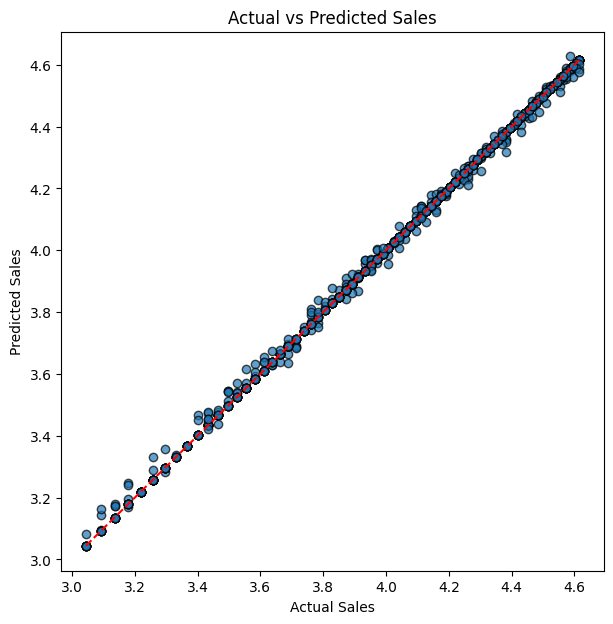

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))
plt.scatter(y, y_pred, alpha=0.7, edgecolor='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # perfect line
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Actual vs Predicted Sales")
plt.show()


In [13]:
import joblib

# 🔹 Save model
joblib.dump(model, "demandforecastingmodel.pkl")

# 🔹 Load model later
loaded_model = joblib.load("demandforecastingmodel.pkl")

# Test prediction
print(loaded_model.predict(X[:5]))


[3.66420941 4.09436093 3.21887299 4.15888694 3.81131676]


In [14]:
import shutil

# Zip the model file
shutil.make_archive("demandforecastingmodel", 'zip', ".", "demandforecastingmodel.pkl")


'/kaggle/working/demandforecastingmodel.zip'